In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
%matplotlib inline

In [185]:
df = pd.read_csv('housing_in_london_monthly_variables.csv')
df.head(5)
df.describe()


,average_price,houses_sold,no_of_crimes,borough_flag
count,1.354900e+04,13455.000000,7439.000000,13549.000000
mean,2.635197e+05,3893.994129,2158.352063,0.733338
std,1.876175e+05,12114.402476,902.087742,0.442230
min,4.072200e+04,2.000000,0.000000,0.000000
25%,1.323800e+05,247.000000,1623.000000,0.000000
50%,2.229190e+05,371.000000,2132.000000,1.000000
75%,3.368430e+05,3146.000000,2582.000000,1.000000
max,1.463378e+06,132163.000000,7461.000000,1.000000


In [186]:
df.isnull().sum()

date                0
area                0
average_price       0
code                0
houses_sold        94
no_of_crimes     6110
borough_flag        0
dtype: int64

In [187]:
df_clean = df.drop(columns = ['no_of_crimes'])
df_clean['houses_sold'].fillna(df_clean.groupby('area')['houses_sold'].transform('mean'), inplace = True)
df_boroughs = df_clean[df['borough_flag'] == 1]
df_boroughs_mean = round(df_boroughs.groupby('area')['average_price'].mean(),2).sort_values().to_frame().reset_index()

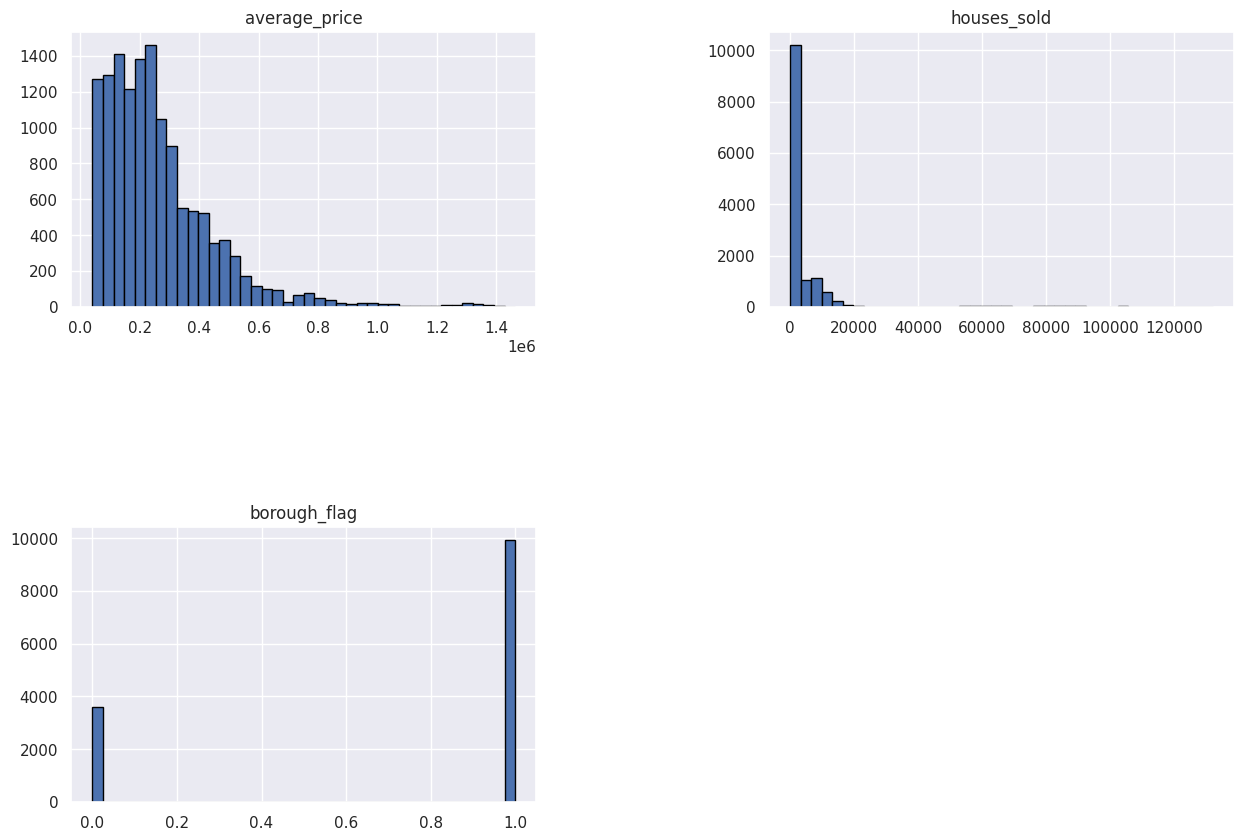

In [188]:
df_clean.hist(figsize=(15, 10), bins=40, edgecolor="black")
plt.subplots_adjust(hspace=0.8, wspace=0.5)
plt.show()

<Axes: xlabel='date', ylabel='average_price'>

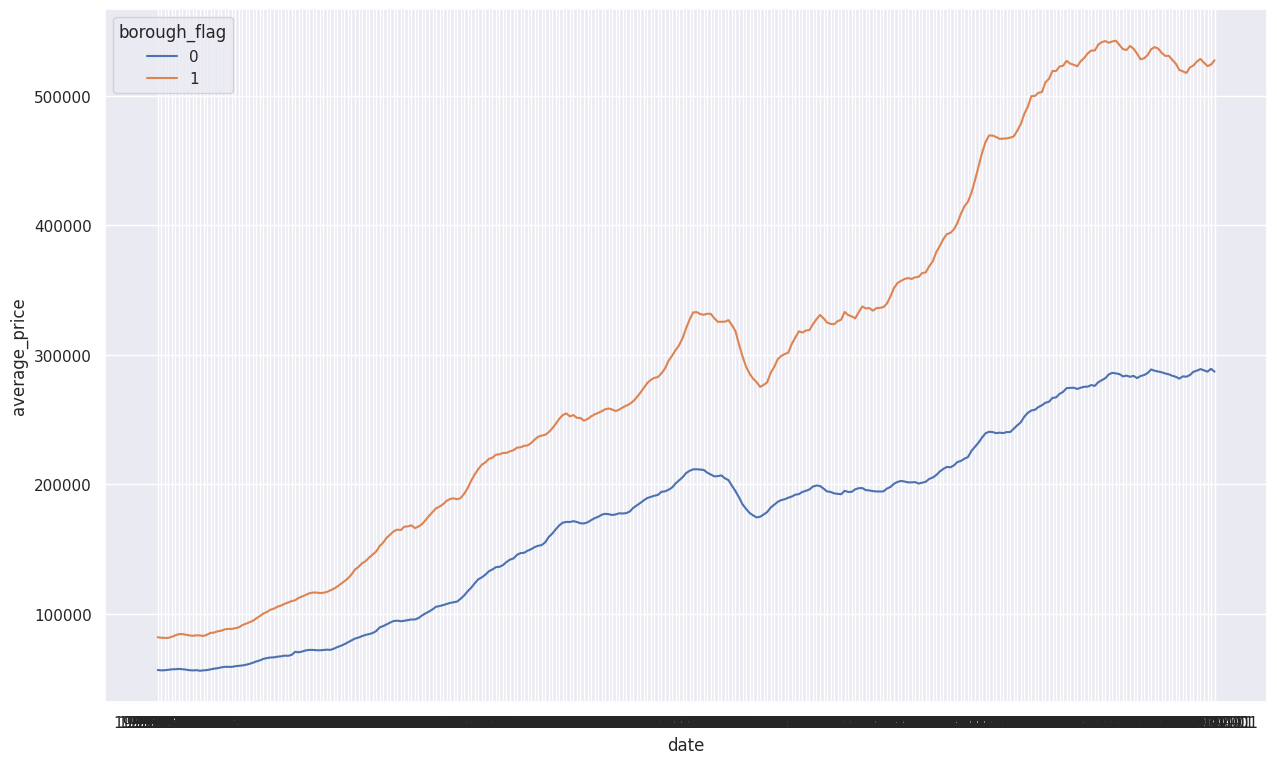

In [189]:
df_date_price = df_clean.groupby(['date','borough_flag'])['average_price'].mean().to_frame().reset_index()
sns.lineplot(df_date_price, x='date', y='average_price', hue="borough_flag")

<Axes: xlabel='average_price', ylabel='area'>

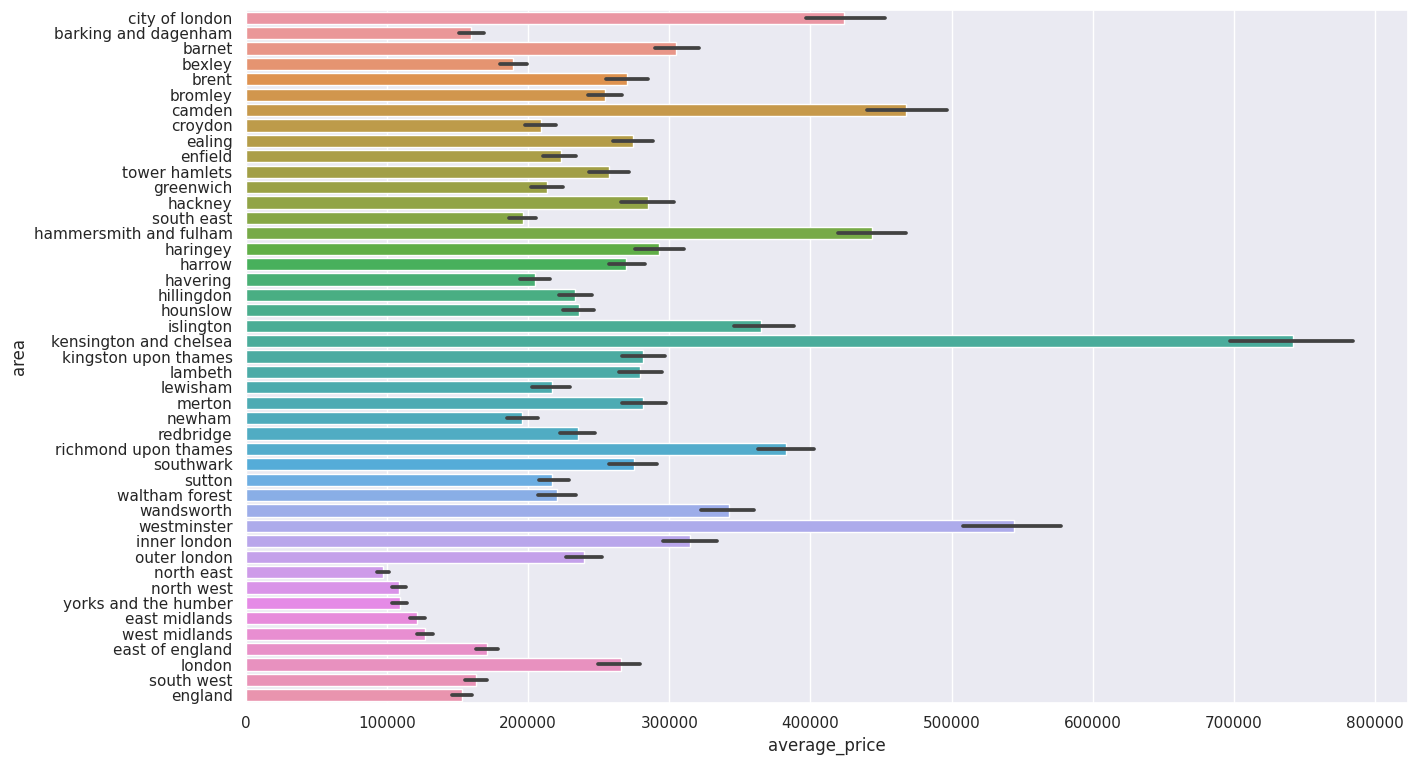

In [81]:
sns.set(font_scale = 1, rc={'figure.figsize':(15,9)})
boroughs = df_clean[df['borough_flag'] == 1]['area'].unique()
boroughs_to_hide = np.delete(boroughs, [0,6,13,20,32])
sns.barplot(data=df, x="average_price", y="area")

<Axes: xlabel='date', ylabel='average_price'>

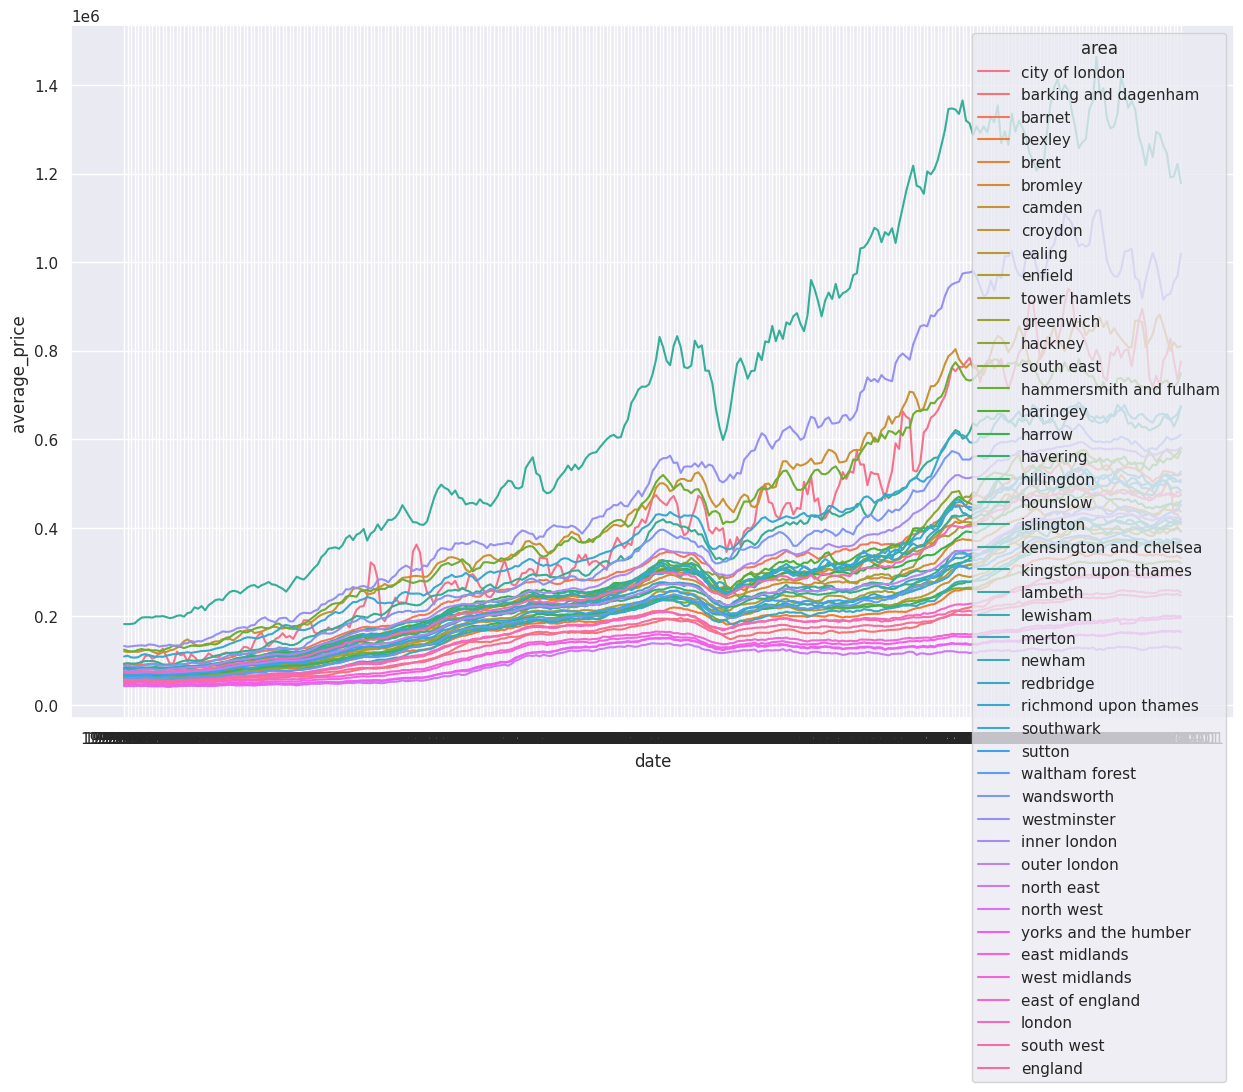

In [82]:
sns.lineplot(df_clean, x='date', y='average_price', hue="area")

In [83]:
import geopandas as gpd
!wget 'https://s3-eu-west-1.amazonaws.com/londondatastore-upload/statistical-gis-boundaries-london.zip'
!unzip './statistical-gis-boundaries-london.zip' -d './'

--2023-08-02 09:34:25--  https://s3-eu-west-1.amazonaws.com/londondatastore-upload/statistical-gis-boundaries-london.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.92.32.104, 52.218.44.192, 52.218.102.67, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.92.32.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26987277 (26M) [application/zip]
Saving to: ‘statistical-gis-boundaries-london.zip.1’

statistical-gis-bou 100%[===================>]  25.74M  11.3MB/s    in 2.3s    

2023-08-02 09:34:28 (11.3 MB/s) - ‘statistical-gis-boundaries-london.zip.1’ saved [26987277/26987277]

Archive:  ./statistical-gis-boundaries-london.zip
statistical-gis-boundaries-london/:  ucsize 40960 <> csize 0 for STORED entry
         continuing with "compressed" size value
replace ./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [190]:
fp = './statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)
map_df = map_df[['NAME', 'geometry']]
map_df = map_df.rename(columns={'NAME': 'area'})
map_df = map_df.rename(columns = {'gss_code': 'code'})
map_df['area'] = map_df['area'].str.lower()
map_df['area'] = map_df['area'].str.replace('&','and')

In [191]:
df = df_clean.set_index(pd.to_datetime(df['date']))
df_boroughs_date = df[df['borough_flag'] == 1]
df_boroughs_date_year = df_boroughs_date.groupby('area').resample('y')['average_price'].mean()
yearly_prices_london_df_map = pd.DataFrame(df_boroughs_date_year)
yearly_prices_london_df_map = yearly_prices_london_df_map.reset_index()

price_map = map_df.set_index('area').join(yearly_prices_london_df_map.set_index('area'))
price_map = price_map.reset_index()

price_map = price_map[price_map['date'] == '2019-12-31']

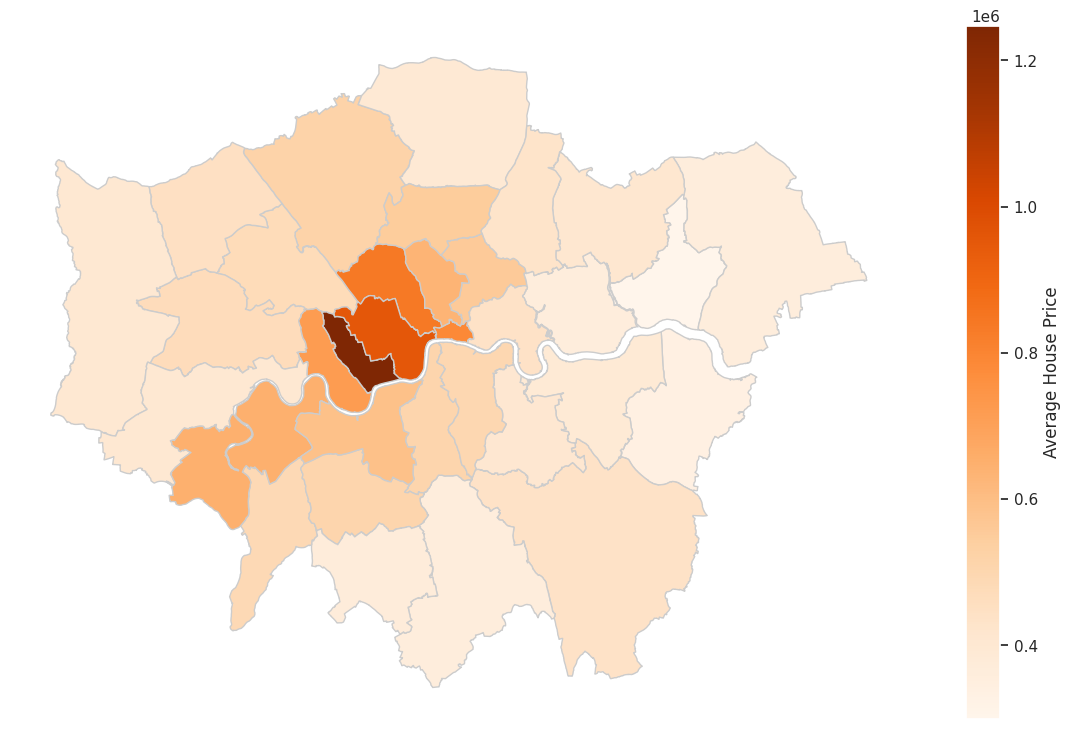

In [192]:
fig, ax = plt.subplots(1, figsize=(15, 9))

price_map.plot(column= 'average_price',
               cmap='Oranges',
               linewidth=1,
               ax=ax,
               edgecolor='0.8',
               legend=True,
               legend_kwds={'label': "Average House Price",
                           'orientation': "vertical"})
ax.axis('off')
plt.show()

In [64]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from  sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.validation import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

In [202]:
# def preprocessing_data(df = df_boroughs, training_size = 0.8):
#   df_predict = df.drop(columns =['borough_flag'])
#   df_predict = df_predict.drop(columns =['date'])

#   df_predict['code']=df_predict.code.str.replace('E','').astype(float)

#   df_predict['area'] = pd.factorize(df_predict.area)[0]
#   df_predict['area'] = df_predict['area'].astype("float")
#   x = df_predict.drop(columns = ['average_price'])
#   y = df_predict['average_price']

#   x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= training_size, shuffle=True, random_state=42)

#   scale = StandardScaler()
#   scale.fit(x_train)
#   x_train = pd.DataFrame(scale.transform(x_train), index=x_train.index, columns=x_train.columns)
#   x_test = pd.DataFrame(scale.transform(x_test), index=x_test.index, columns=x_test.columns)

#   return x_train, x_test, y_train, y_test

# x_train, x_test, y_train, y_test = preprocessing_data()
df_clean['area'] = pd.factorize(df_clean.area)[0]
df_clean['area'] = df_clean['area'].astype("float")


df_clean.info()
x = df_clean.drop('average_price', axis=1)
y = df_clean['average_price']
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.25)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Columns: 306 entries, area to date_2020-01-01
dtypes: float64(3), int64(2), uint8(301)
memory usage: 4.4 MB


In [177]:
RFM = RandomForestRegressor()
parameters = {    'n_estimators' : [None, 100 , 500, 1000],
                  'max_depth'    : [2, 3, 5, None]
                 }

G_RFM = GridSearchCV(estimator=RFM, param_grid = parameters, cv = 3, n_jobs=-1)
G_RFM.fit(x_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",G_RFM.best_estimator_)
print("\n The best score across ALL searched params:\n",G_RFM.best_score_)
print("\n The best parameters across ALL searched params:\n",G_RFM.best_params_)

KeyboardInterrupt: ignored

In [207]:
knn = KNeighborsRegressor()
parameters = {'n_neighbors' : [2, 3, 5, 7],
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
               }

grid_knn = GridSearchCV(estimator= knn, param_grid = parameters, cv = 3, n_jobs=-1)
grid_knn.fit(x_train, y_train)

# Print Best hyperparameters
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_knn.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_knn.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_knn.best_params_)

KeyboardInterrupt: ignored

In [209]:
from sklearn.tree import DecisionTreeRegressor
model=DecisionTreeRegressor(random_state=0,min_samples_split=3)
model.fit(x_train ,y_train)
prediction=(model.predict(x_test).astype(int))
print("predictions:",prediction)
from sklearn.metrics import r2_score
r2_score(prediction,y_test)

predictions: [ 90603 139652  94866 ... 138774 246961  79302]


0.35855009650989544

In [208]:
knnr = KNeighborsRegressor()
knnr.fit(x_train,y_train)
knnr.score(x_test,y_test)

0.42678846566598705